## __Predicting Loan Repayment__

Here is the meaning of each column:

__Variables Table__

| Variable Name | Description  |
| ------------- | -------------- |
| credit.policy | 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise |
| purpose | The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other") |
| int.rate | The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates |
| installment | The monthly installments owed by the borrower if the loan is funded |
| log.annual.inc | The natural log of the self-reported annual income of the borrower |
| dti | The debt-to-income ratio of the borrower (amount of debt divided by annual income) |
| fico | The FICO credit score of the borrower |
| days.with.cr.line | The number of days the borrower has had a credit line |
| revol.bal | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle) |
| revol.util | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available) |
| inq.last.6mths | The borrower's number of inquiries by creditors in the last 6 months |
| delinq.2yrs | The number of times the borrower had been 30+ days past due on a payment in the past 2 years |
| pub.rec | The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments) |


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTENC, ADASYN

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pickle

from sklearn import metrics

pd.set_option('display.max_columns', None) # shows all columns
# pd.options.display.float_format = '{:.3f}'.format

## Deep Learning
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, CategoricalAccuracy
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf


In [2]:
import tensorflow
tensorflow.__version__

'2.10.0'

In [3]:
data = pd.read_csv("data/loan_data.csv")
data

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [5]:
data.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

## __Data Understanding__

### __Checking Duplicated Data__
<div  dir='rtl' style="text-align: justify;text-justify: inter-word;font-family:tahoma;font-size: 17px;">
داده ی تکراری نداریم:
</div>

In [6]:
## Checking Duplicates
print(f"Number of duplicated data: {data.duplicated().sum()}")

Number of duplicated data: 0


### __Checking Missing Values__
<div  dir='rtl' style="text-align: justify;text-justify: inter-word;font-family:tahoma;font-size: 17px;">
داده ی null نداریم:
</div>

In [7]:
data.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

In [8]:
data["credit.policy"].value_counts()

credit.policy
1    7710
0    1868
Name: count, dtype: int64

In [9]:
data["credit.policy"] = data["credit.policy"].astype("object")

## __Data Preprocessing__

### Splitting data to train, test and validation

In [10]:
data_train, data_val_test = train_test_split(data, test_size=0.25, random_state=364)
data_val, data_test = train_test_split(data_val_test, test_size=0.50, random_state=364)

## Check the shape of train, test and validation data:
print("Train data shape: ", data_train.shape)
print("Validation data shape: ", data_val.shape)
print("Test data shape: ", data_test.shape)

Train data shape:  (7183, 14)
Validation data shape:  (1197, 14)
Test data shape:  (1198, 14)


<div  dir='rtl' style="text-align: justify;text-justify: inter-word;font-family:tahoma;font-size: 17px;">
داده های آموزشی بالانس نیستند:
</div>

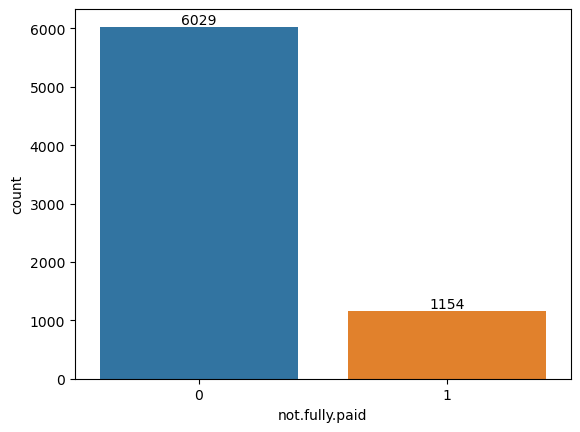

In [11]:
ax = sns.countplot(data= data_train, x="not.fully.paid");
ax.bar_label(ax.containers[-1], label_type='edge');

In [12]:
## Converting train, test and validation data to numpy arrays:
## train data:
X_train = data_train.iloc[:,:-1].values
y_train = data_train.iloc[:,-1].values
## test data:
X_test = data_test.iloc[:,:-1].values
y_test = data_test.iloc[:,-1].values
## validation data:
X_val = data_val.iloc[:,:-1].values
y_val = data_val.iloc[:,-1].values

## checking data to ensure code correctness and bug-free execution
print("The shape of 'X_train': ", X_train.shape)
print("The shape of 'y_train': ", y_train.shape)
i= 0
print(f"\nX_train[{i},:]:\n{X_train[i,:]}")
print(f"y_train[{i}]: {y_train[i]}")

The shape of 'X_train':  (7183, 13)
The shape of 'y_train':  (7183,)

X_train[0,:]:
[0 'credit_card' 0.1482 345.78 11.51292546 9.73 647 4799.958333 19717 95.7
 1 0 1]
y_train[0]: 1


<div  dir='rtl' style="text-align: justify;text-justify: inter-word;font-family:tahoma;font-size: 17px;">
داده های آموزشی را بالانس می کنیم:
</div>

### Balancing the Train Data using __Synthetic Minority Oversampling Technique (SMOTE)__

In [13]:
print("Before Balancing:", np.unique(y_train, return_counts=True))

smote = SMOTENC(categorical_features=[0, 1])
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After Balancing:", np.unique(y_train, return_counts=True))

## checking data to ensure code correctness and bug-free execution
print("\nThe shape of 'X_train': ", X_train.shape)
print("The shape of 'y_train': ", y_train.shape)
i= 0
print(f"\nX_train[{i},:]:\n{X_train[i,:]}")
print(f"y_train[{i}]: {y_train[i]}")

Before Balancing: (array([0, 1], dtype=int64), array([6029, 1154], dtype=int64))
After Balancing: (array([0, 1], dtype=int64), array([6029, 6029], dtype=int64))

The shape of 'X_train':  (12058, 13)
The shape of 'y_train':  (12058,)

X_train[0,:]:
[0 'credit_card' 0.1482 345.78 11.51292546 9.73 647.0 4799.958333 19717.0
 95.7 1.0 0.0 1.0]
y_train[0]: 1


### Balancing the Train Data using __Adaptive Synthetic Minority Oversampling Technique (ADASYN)__

In [14]:
# print("Before Balancing:", np.unique(y_train, return_counts=True))

# adasyn = ADASYN(sampling_strategy=0.8, random_state=358, n_neighbors=3)
# X_train, y_train = adasyn.fit_resample(X_train, y_train)

# print("After Balancing:", np.unique(y_train, return_counts=True))

# ## checking data to ensure code correctness and bug-free execution
# print(X_train.shape)
# print(y_train.shape)
# print(X_train[0,:])
# print(y_train[0])

### 1. One-Hot Encoding - 'credit.policy' and 'purpose' columns

<div  dir='rtl' style="text-align: justify;text-justify: inter-word;font-family:tahoma;font-size: 17px;">

<br>
دو ستون غیر عددی داریم که باید One-Hot Encoding بشوند:
</div>

In [15]:
print(np.unique(X_train[:, 1]))
print(np.unique(X_train[:, 0]))

['all_other' 'credit_card' 'debt_consolidation' 'educational'
 'home_improvement' 'major_purchase' 'small_business']
[0 1]


In [16]:
ct_ohe = ColumnTransformer(transformers= [('one_hot_encoder', OneHotEncoder(), [0, 1])],
                                               remainder='passthrough', sparse_threshold=0)

X_train = ct_ohe.fit_transform(X_train)

## checking data to ensure code correctness and bug-free execution
print("The shape of 'X_train': ", X_train.shape)
i= 0
print(f"X_train[{i},:]:\n{X_train[i,:]}")

The shape of 'X_train':  (12058, 20)
X_train[0,:]:
[1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.1482 345.78 11.51292546 9.73 647.0
 4799.958333 19717.0 95.7 1.0 0.0 1.0]


### 2. Scaling

In [17]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

## checking data to ensure code correctness and bug-free execution
print(X_train.shape)
print(X_train[0,:])

(12058, 20)
[1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.56393862 0.35708027 0.56804289
 0.32476636 0.1627907  0.2646013  0.01633069 0.80420168 0.03225806
 0.         0.2       ]


### Saving transformers:

In [18]:
## Save transformer to H.D.D.:

with open('./transformers/ct_ohe.h5', 'wb') as f:
    pickle.dump(ct_ohe, f)

with open('./transformers/scaler.h5', 'wb') as f:
    pickle.dump(scaler, f)

### Loading transformers

In [19]:
## Loads transformers:

with open('./transformers/ct_ohe.h5', 'rb') as f:
    ct_ohe = pickle.load(f)

with open('./transformers/scaler.h5', 'rb') as f:
    scaler = pickle.load(f)

### Preparing `X_test` and `X_val`:

In [20]:
## test data
print(X_test.shape, y_test.shape)

X_test = ct_ohe.transform(X_test)
X_test = scaler.transform(X_test)

print(X_test.shape, y_test.shape)

## validation data
print(X_val.shape, y_val.shape)

X_val = ct_ohe.transform(X_val)
X_val = scaler.transform(X_val)

print(X_val.shape, y_val.shape)

(1198, 13) (1198,)
(1198, 20) (1198,)
(1197, 13) (1197,)
(1197, 20) (1197,)


In [21]:
## a function for plotting loss and accuracy using history of training 
def plot_loss_acc(hist):
    fig , axes = plt.subplots(nrows= 1, ncols= 2, figsize= (15, 4))
    # fig.tight_layout(pad=2.5)
    fig.suptitle("Loss and Accuracy for Train and Validation data during training", fontsize= 15,  fontweight='bold');
    ## Acuracy
    axes[0].plot(hist.history['accuracy'])
    axes[0].plot(hist.history['val_accuracy'])
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("accuracy")
    axes[0].legend(['train', 'validation'], loc='upper left')
    ## Loss
    axes[1].plot(hist.history['loss'])
    axes[1].plot(hist.history['val_loss'])
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("loss")
    axes[1].legend(['train', 'validation'], loc='upper left')

    plt.show()

## __Deep Learning Model: First Approach__

### __Defining Model__

In [22]:
## Feedforward Neural Networks (FNN)
model = Sequential([

    Dense(25, activation="relu", input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(45, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),

    Dense(65, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(35, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),

    Dense(15, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                525       
                                                                 
 batch_normalization (BatchN  (None, 25)               100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 45)                1170      
                                                                 
 batch_normalization_1 (Batc  (None, 45)               180       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 45)                0

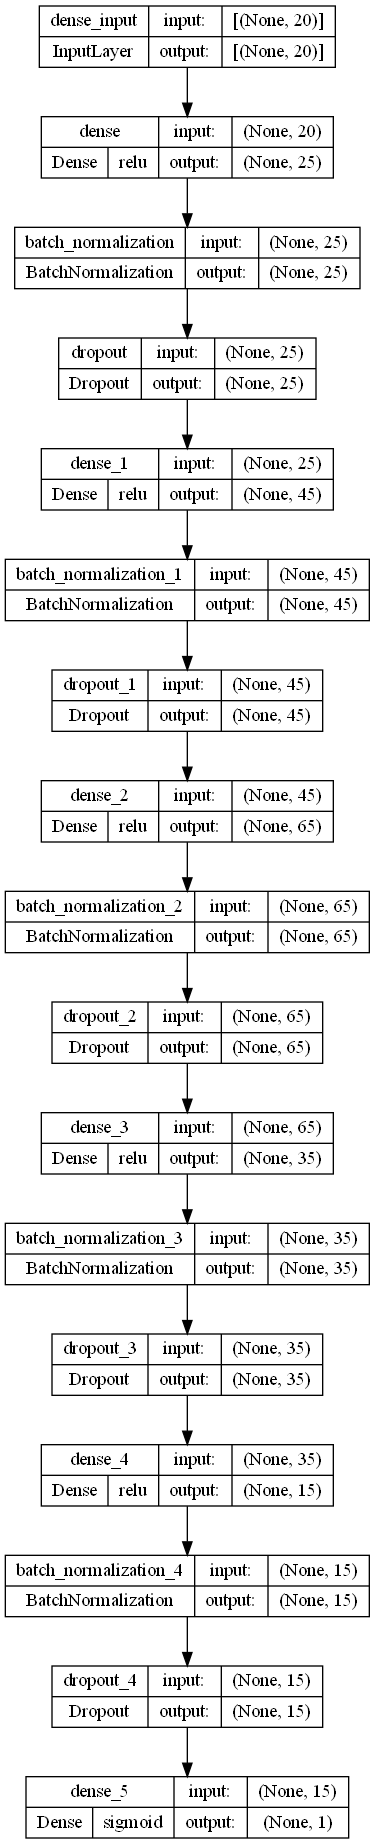

In [23]:
plot_model(model, show_layer_activations=True, show_shapes=True)

### __Compiling Model__

In [24]:
# tensorflow.keras.metrics.F1Score(average='macro', threshold=None, name="f1_score", dtype=None)

In [25]:
model.compile(optimizer=Adam(0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])


### __Fitting Model__

In [26]:
## Defining callbacks
mch = ModelCheckpoint('./models/dl_model_simple.keras', monitor='val_loss', mode='min', save_best_only=True)

## Fitting model
history_model = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[mch],  batch_size=64) 

Epoch 1/200
189/189 [==============================] - 3s 7ms/step - loss: 0.7135 - accuracy: 0.5692 - val_loss: 0.7264 - val_accuracy: 0.4119
Epoch 2/200
189/189 [==============================] - 1s 5ms/step - loss: 0.6616 - accuracy: 0.6079 - val_loss: 0.7226 - val_accuracy: 0.4712
Epoch 3/200
189/189 [==============================] - 1s 4ms/step - loss: 0.6462 - accuracy: 0.6271 - val_loss: 0.7048 - val_accuracy: 0.4887
Epoch 4/200
189/189 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.6323 - val_loss: 0.6453 - val_accuracy: 0.5589
Epoch 5/200
189/189 [==============================] - 1s 3ms/step - loss: 0.6330 - accuracy: 0.6392 - val_loss: 0.6602 - val_accuracy: 0.5430
Epoch 6/200
189/189 [==============================] - 1s 3ms/step - loss: 0.6240 - accuracy: 0.6485 - val_loss: 0.6808 - val_accuracy: 0.5297
Epoch 7/200
189/189 [==============================] - 1s 4ms/step - loss: 0.6196 - accuracy: 0.6562 - val_loss: 0.6246 - val_accuracy: 0.6065

### __Plot Accuracy and Loss__

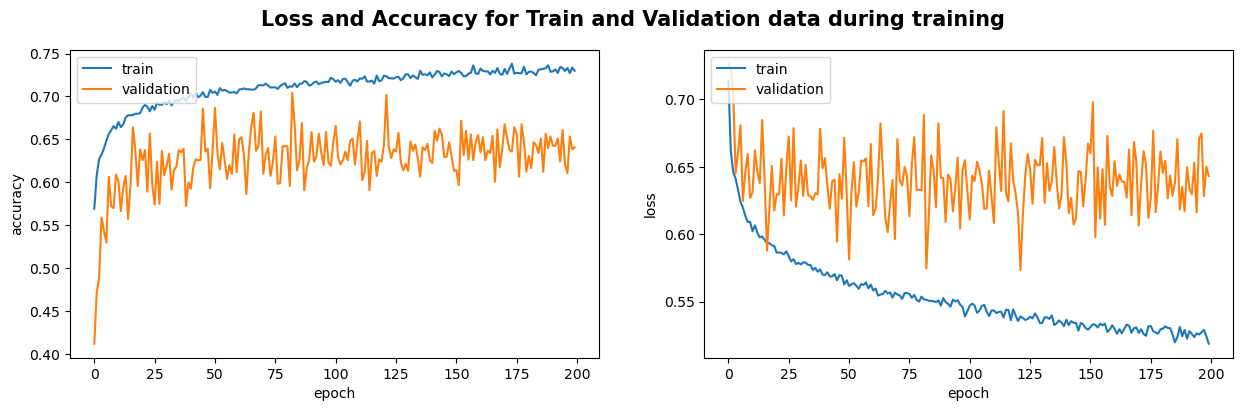

In [27]:
plot_loss_acc(history_model)

### __Evaluating Model__

In [28]:
from keras.models import load_model

## Loading the best model on validation data
best_model_s = load_model('models/dl_model_simple.keras')

## predict on test dataset
y_true = y_test
y_pred = best_model_s.predict(X_test)

## Threshold: Binary
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

print(metrics.classification_report(y_true, y_pred))

38/38 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1010
           1       0.21      0.35      0.26       188

    accuracy                           0.70      1198
   macro avg       0.54      0.55      0.54      1198
weighted avg       0.76      0.70      0.72      1198



## __Deep Learning Model: Second Approach: Multi-channel DL Model__

In [29]:
print(X_train[0,:9]) # One-Hot Encoding part
print(X_train[0,9:]) # Numerical part

[1. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.56393862 0.35708027 0.56804289 0.32476636 0.1627907  0.2646013
 0.01633069 0.80420168 0.03225806 0.         0.2       ]


In [30]:
mch_model_1 = Sequential()
mch_model_1.add(Dense(11, activation="relu", input_shape=(X_train[:,:9].shape[1],)))
mch_model_1.add(BatchNormalization())
mch_model_1.add(Dropout(0.2))

mch_model_1.add(Dense(25, activation="relu"))
mch_model_1.add(BatchNormalization())
mch_model_1.add(Dropout(0.2))

mch_model_1.add(Dense(45, activation="relu"))
mch_model_1.add(BatchNormalization())
mch_model_1.add(Dropout(0.2))

mch_model_1.add(Dense(20, activation="relu"))
mch_model_1.add(BatchNormalization())
mch_model_1.add(Dropout(0.2))

mch_model_1.add(Dense(4, activation="relu"))

In [31]:
# mch_model_1.summary()

In [32]:
mch_model_2 = Sequential()
mch_model_2.add(Dense(9, activation="relu", input_shape=(X_train[:,9:].shape[1],)))
mch_model_2.add(BatchNormalization())
mch_model_2.add(Dropout(0.2))

mch_model_2.add(Dense(25, activation="relu"))
mch_model_2.add(BatchNormalization())
mch_model_2.add(Dropout(0.2))

mch_model_2.add(Dense(45, activation="relu"))
mch_model_2.add(BatchNormalization())
mch_model_2.add(Dropout(0.2))

mch_model_2.add(Dense(20, activation="relu"))
mch_model_2.add(BatchNormalization())
mch_model_2.add(Dropout(0.2))

mch_model_2.add(Dense(4, activation="relu"))


In [33]:
# mch_model_2.summary()

In [34]:
densef1 = Dense(4, activation='relu')(concatenate([mch_model_1.output, mch_model_2.output]))
densef2 = Dense(1, activation='sigmoid')(densef1)

mch_model = Model(inputs=[mch_model_1.input, mch_model_2.input], outputs=densef2)


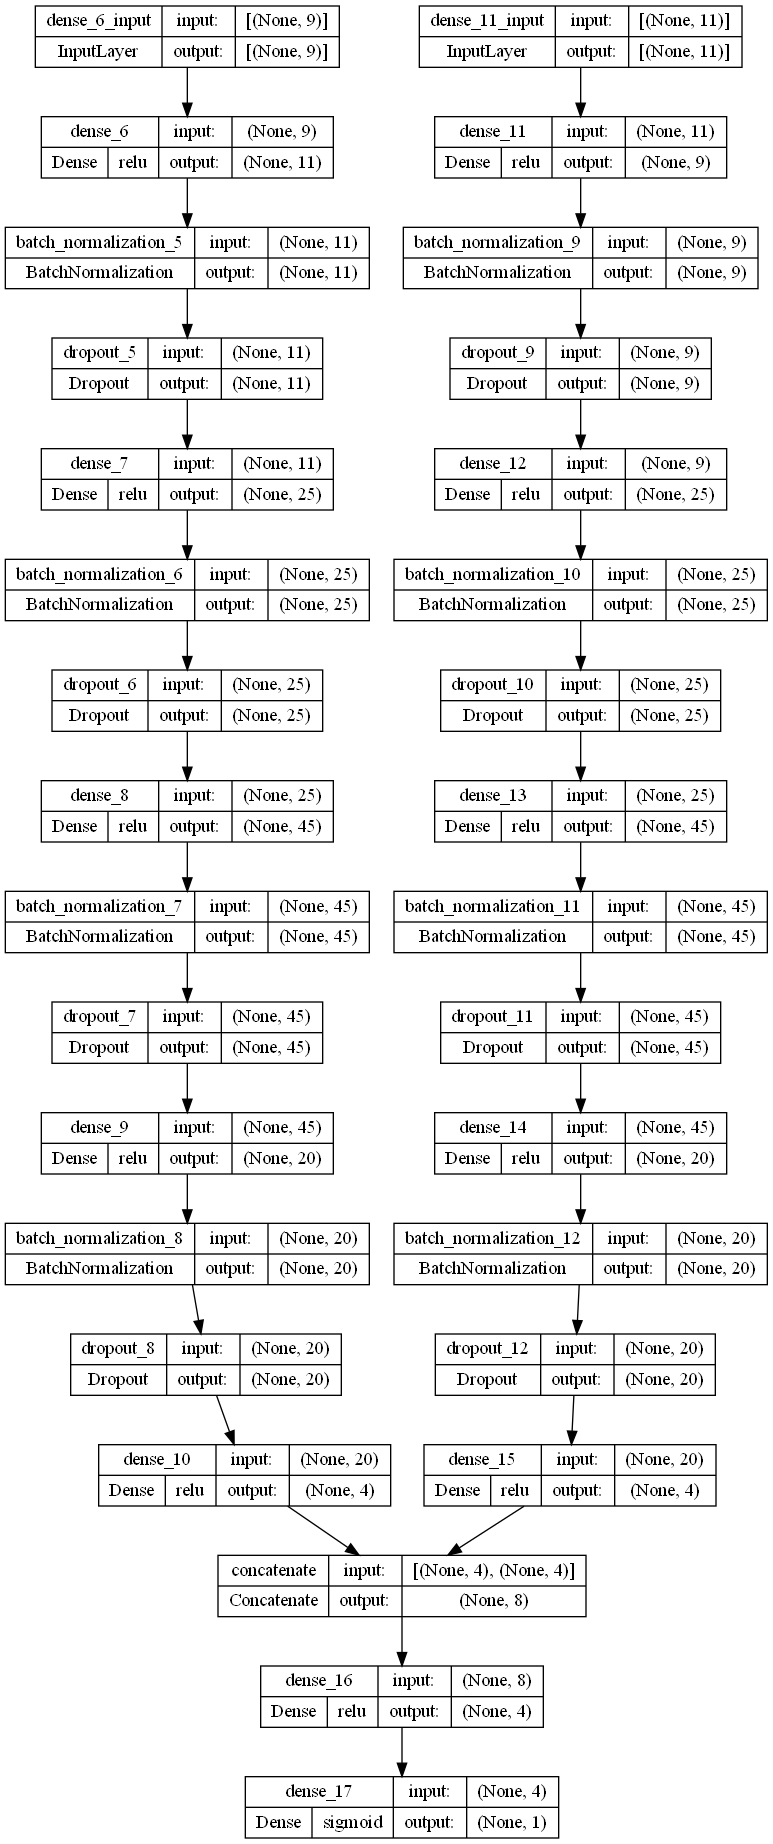

In [35]:
plot_model(mch_model, show_layer_activations=True, show_shapes=True)

### __Compiling Model__

In [36]:
mch_model.compile(optimizer=Adam(0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])


### __Fitting Model__

In [37]:
## Defining callbacks
mch = ModelCheckpoint('./models/dl_model_mch.keras', monitor='val_loss', mode='min', save_best_only=True)

## Fitting model
history_mch_model = mch_model.fit([X_train[:,:9], X_train[:,9:]], y_train, 
                        validation_data= ([X_val[:,:9], X_val[:,9:]], y_val), 
                        epochs= 200, callbacks= [mch],  batch_size= 64, verbose= 2) 

Epoch 1/200
189/189 - 9s - loss: 0.6942 - accuracy: 0.5233 - val_loss: 0.7234 - val_accuracy: 0.2206 - 9s/epoch - 47ms/step
Epoch 2/200
189/189 - 1s - loss: 0.6741 - accuracy: 0.5792 - val_loss: 0.7284 - val_accuracy: 0.3885 - 1s/epoch - 7ms/step
Epoch 3/200
189/189 - 1s - loss: 0.6627 - accuracy: 0.6022 - val_loss: 0.6852 - val_accuracy: 0.4637 - 1s/epoch - 8ms/step
Epoch 4/200
189/189 - 1s - loss: 0.6583 - accuracy: 0.6096 - val_loss: 0.6643 - val_accuracy: 0.5038 - 1s/epoch - 8ms/step
Epoch 5/200
189/189 - 1s - loss: 0.6520 - accuracy: 0.6196 - val_loss: 0.6707 - val_accuracy: 0.5096 - 1s/epoch - 7ms/step
Epoch 6/200
189/189 - 1s - loss: 0.6450 - accuracy: 0.6292 - val_loss: 0.6616 - val_accuracy: 0.5313 - 1s/epoch - 8ms/step
Epoch 7/200
189/189 - 1s - loss: 0.6462 - accuracy: 0.6301 - val_loss: 0.6844 - val_accuracy: 0.5129 - 1s/epoch - 7ms/step
Epoch 8/200
189/189 - 1s - loss: 0.6403 - accuracy: 0.6306 - val_loss: 0.6781 - val_accuracy: 0.5230 - 1s/epoch - 7ms/step
Epoch 9/200
189

### __Plot Accuracy and Loss__

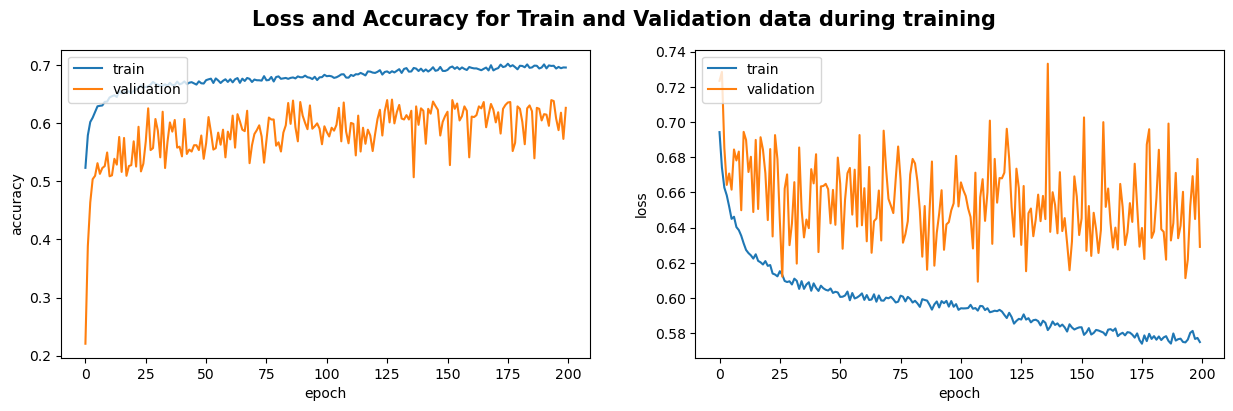

In [38]:
plot_loss_acc(history_mch_model)

### __Evaluating Model__

In [39]:
from keras.models import load_model

## Loading the best model on validation data
best_model = load_model('models/dl_model_mch.keras')

## predict on test dataset
y_true = y_test
y_pred = best_model.predict([X_test[:,:9], X_test[:,9:]])

## Threshold: Binary
y_pred[y_pred >= 0.50] = 1
y_pred[y_pred < 0.50] = 0

print(metrics.classification_report(y_true, y_pred))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      1010
           1       0.23      0.54      0.32       188

    accuracy                           0.65      1198
   macro avg       0.56      0.60      0.54      1198
weighted avg       0.78      0.65      0.69      1198

